Introduction 
Sudden changes in heart rate can have serious consequences, such as stroke, heart failure, cardiac arrest, and death. Taking preventive measures for heart disease is paramount and AI can be used to make more accurate predictions in order to identify and treat such issues in the early stages. In this blog, the power of Machine Learning will be harnessed to predict heart rate using Time Series Forecasting with Python. We will go through the entire process and show you how to do this.

Time series forecasting is a method of using models to predict future values of a metric based on its past data. This data is recorded at regular intervals, such as hourly, daily, weekly, monthly, quarterly or annually. By fitting models to the historical data, it is possible to make predictions about what will happen in the future.

Accurate forecasting of time series data can be of great commercial benefit, particularly in the healthcare sector where it is essential for successful business planning, procurement, disease predictions, and production. Forecasting helps to save costs and is a key factor in achieving success. It uses historical data to make predictions about future data.

The purpose of this task is to construct a useful time series model with the help of a medical data set that includes four hours of data from a patient's sensors. In particular, we will use this data to anticipate the next 20 minutes of the patient's heart rate (Lifetouch Heart Rate).

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
# Data Manipulation libraries
import numpy as np 
import pandas as pd
from   pandas import DataFrame
# Data Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
# Statistical analysis libraries 
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from dateutil.parser import parse 
import pickle
%matplotlib inline
plt.rcParams.update({'figure.figsize': (12, 8), 'figure.dpi': 100})
import warnings
warnings.filterwarnings("ignore")

## Load the datasets

In [ ]:
input_file = '/content/PT_Train.csv'
# Target 
input_target = 'Lifetouch Heart Rate'
# Date column name
input_date = 'Timestamp (GMT)'
#Exogenous variable
input_ex_variable = 'Oximeter SpO2'
# Handling missing value
input_treat_missing_value = 'bfill' 
# choose how to handle missing values from 'ffill','bfill' 
# Box-cox transformation flag
input_transform_flag = 'Yes' 
# Seasonality
input_seasonality = 12
input_order = (0, 1 , 2)
input_seasonal_order = (2, 1, 0, input_seasonality)
 # choose the forecasting algorithm from these --> 
 # [auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters]'
input_ts_algo = 'auto_arima'

Before attempting to tackle the problem, it is essential to have a good understanding of the data. To gain this, it is important to get the descriptive statistics of the data, as well as obtain information about any missing values.

In [ ]:
# Read data in form of a csv file
df = pd.read_csv(input_file)

df[input_date] = pd.to_datetime(df[input_date])
df['Lifetouch Heart Rate'] = df['Lifetouch Heart Rate'].astype(float)


df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,2015-08-17 15:09:00,139.0,41,NaN,NaN
1,2015-08-17 15:10:00,144.0,40,92.0,140.0
2,2015-08-17 15:11:00,140.0,42,89.0,144.0
3,2015-08-17 15:12:00,138.0,45,93.0,141.0
4,2015-08-17 15:13:00,133.0,42,94.0,134.0


In [ ]:
df.shape

(226, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Timestamp (GMT)             226 non-null    datetime64[ns]
 1   Lifetouch Heart Rate        226 non-null    float64       
 2   Lifetouch Respiration Rate  226 non-null    int64         
 3   Oximeter SpO2               191 non-null    float64       
 4   Oximeter Pulse              191 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 9.0 KB


In [ ]:
df.describe()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
count,226.000000,226.000000,191.000000,191.000000
mean,2315.615044,2219.216814,83.450262,126.335079
std,11351.588825,11370.093548,29.802974,46.348142
min,106.000000,34.000000,-1.000000,-1.000000
25%,136.000000,38.000000,92.000000,134.000000
50%,145.000000,46.000000,93.000000,139.000000
75%,156.000000,53.000000,95.000000,149.000000
max,61442.000000,61442.000000,98.000000,166.000000


In [ ]:
# Missing values
df.isna().sum()

Timestamp (GMT)                0
Lifetouch Heart Rate           0
Lifetouch Respiration Rate     0
Oximeter SpO2                 35
Oximeter Pulse                35
dtype: int64

In [ ]:
df = df.ffill()
df = df.bfill()
df.isna().sum()
#df.head()

Timestamp (GMT)               0
Lifetouch Heart Rate          0
Lifetouch Respiration Rate    0
Oximeter SpO2                 0
Oximeter Pulse                0
dtype: int64

In [ ]:
#df.isna().sum()

In [ ]:
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,2015-08-17 15:09:00,139.0,41,92.0,140.0
1,2015-08-17 15:10:00,144.0,40,92.0,140.0
2,2015-08-17 15:11:00,140.0,42,89.0,144.0
3,2015-08-17 15:12:00,138.0,45,93.0,141.0
4,2015-08-17 15:13:00,133.0,42,94.0,134.0


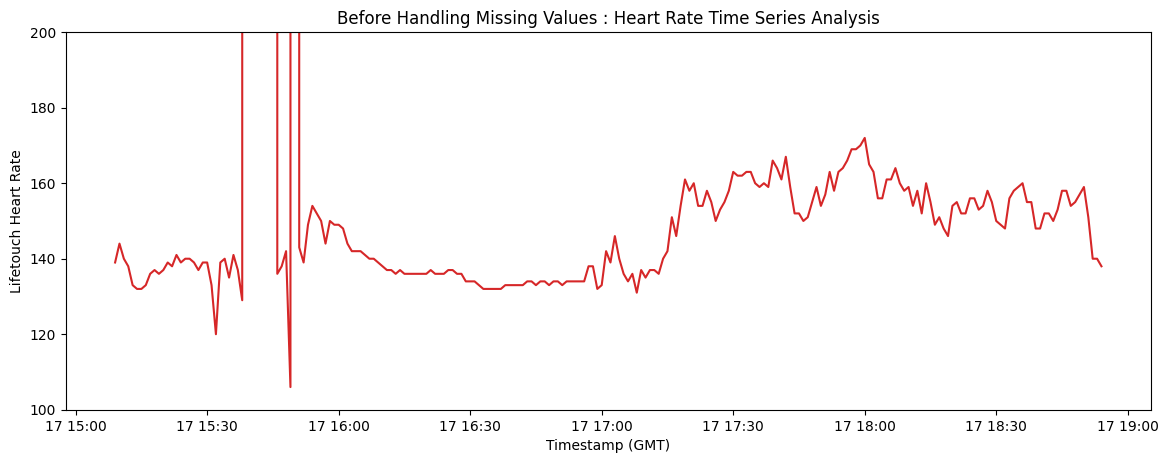

In [ ]:
# Draw line Plot
def plot_df(x, y, title="", xlabel='Timestamp (GMT)', ylabel='Lifetouch Heart Rate', dpi=100):
    plt.figure(figsize=(14,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.ylim(100, 200)

plot_df(x=df[input_date], y=df[input_target], title='Before Handling Missing Values : Heart Rate Time Series Analysis')

In [ ]:
df = df.replace({'Lifetouch Heart Rate':{61441:np.nan, 61442:np.nan}, 'Lifetouch Respiration Rate':{61441:np.nan, 61442:np.nan}})

In [ ]:
df.isnull().sum()

Timestamp (GMT)               0
Lifetouch Heart Rate          8
Lifetouch Respiration Rate    8
Oximeter SpO2                 0
Oximeter Pulse                0
dtype: int64

In [ ]:
df = df.ffill()

In [ ]:
df.isnull().sum()

Timestamp (GMT)               0
Lifetouch Heart Rate          0
Lifetouch Respiration Rate    0
Oximeter SpO2                 0
Oximeter Pulse                0
dtype: int64

In [ ]:
df.to_csv('cleaned_data.csv')

**This code is used to plot a line graph with the x-axis and y-axis from user-specified data. The user can specify a title, x-label, y-label, and dpi (dots per inch). The plot_df() function takes in the x and y values from the user-specified data, as well as the title, xlabel, ylabel, and dpi parameters. The plt.plot() function is used to draw the line graph, and the plt.ylim() function is used to set the y-axis limits.**

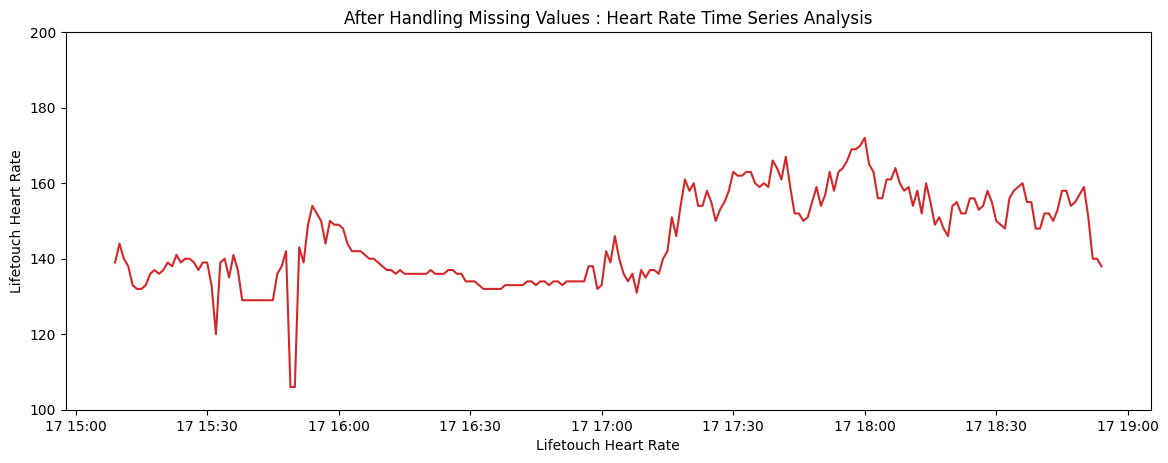

In [ ]:
# Draw line Plot
def plot_df(x, y, title="", xlabel='Lifetouch Heart Rate', ylabel='Lifetouch Heart Rate', dpi=100):
    plt.figure(figsize=(14,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.ylim(100, 200)

plot_df(x=df[input_date], y=df[input_target], title='After Handling Missing Values : Heart Rate Time Series Analysis')

**This code plots a time series analysis of heart rate data. The code uses pandas to read in a dataframe containing a Timestamp column and a Lifetouch Heart Rate column. It then uses matplotlib to plot a filled area chart of the data. The chart shows the heart rate as a function of time, with the x-axis representing the Timestamp and the y-axis representing the Lifetouch Heart Rate. The area between the line and the y-axis is shaded to give a better visual of the changes in heart rate over time. The chart title, x and y labels are also included. The y-axis is also scaled to only show values from 100-200 to focus on the important range.**

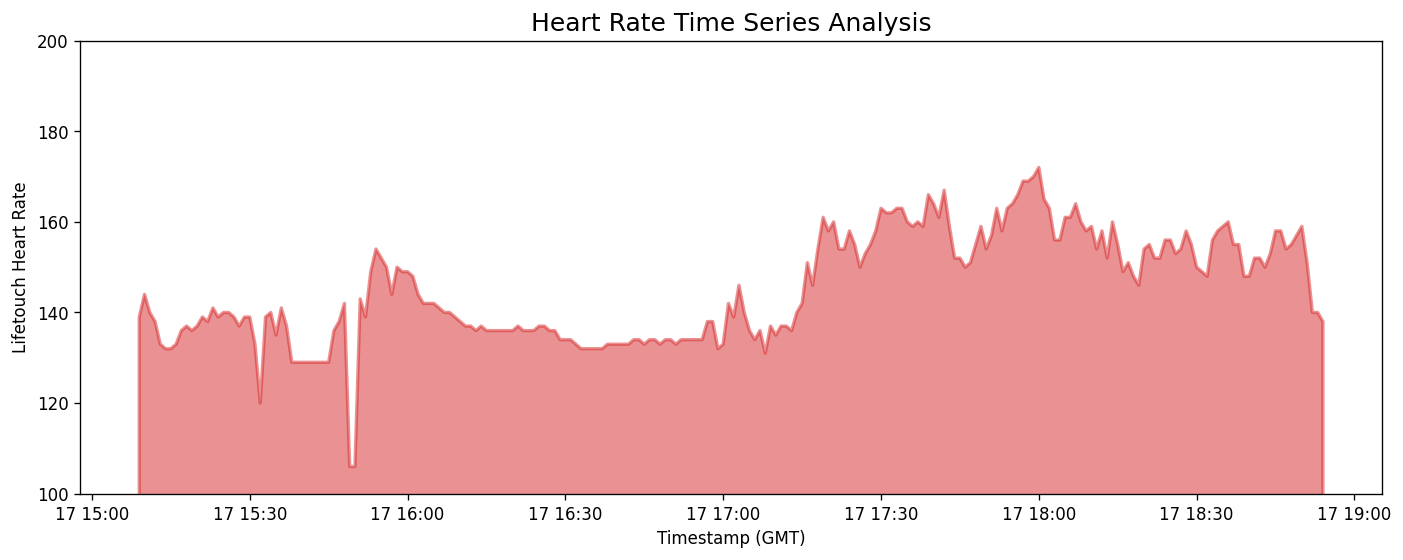

In [ ]:
# Draw plot
x = df[input_date]
y1 = df[input_target].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(14,5), dpi= 120)
plt.fill_between(x, y1=y1, alpha=0.5, linewidth=2, color='tab:red')
plt.title('Heart Rate Time Series Analysis', fontsize=15)
plt.hlines(y=0, xmin=np.min(df['Timestamp (GMT)']), xmax=np.max(df['Timestamp (GMT)']), linewidth=.5)
plt.xlabel('Timestamp (GMT)')
plt.ylabel('Lifetouch Heart Rate')
plt.ylim(100, 200)
plt.show()

**This code creates a figure with a size of 7 x 4 inches and plots a distribution of the target variable from the given dataframe. The distribution is plotted with a kernel density estimation (kde) and is colored red. The plot also has 30 bins. The title of the plot and the limits of the x-axis (from 100 to 180) are also specified in the code.**

We should check the distribution of the time series so that we can decide if we need to transform the data or can be used as it is.
Additionally, it provides insights into the type of distribution the data follows.

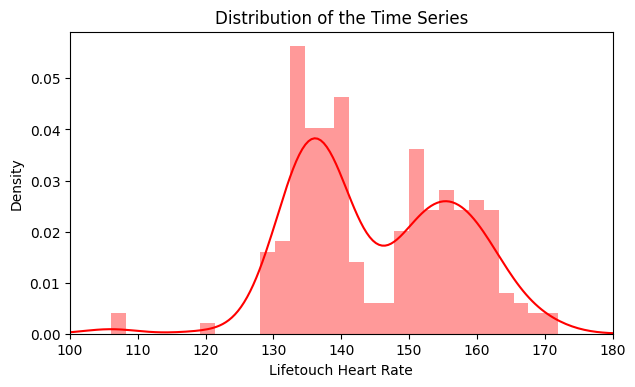

In [ ]:
plt.figure(figsize = (7,4))
sns.distplot(df[input_target], kde = True, color ='red', bins = 30)
plt.title('Distribution of the Time Series', fontsize=12)
plt.xlim(100,180)
plt.show()

Histogram to check the distribution of the attribute

In [ ]:
import scipy.stats as ss
import pylab

**This code is creating a QQ plot to analyze the data in the column 'Lifetouch Heart Rate' from the dataframe 'df'. The QQ plot is used to compare the distribution of the data with a normal distribution. The code creates a figure of size 7x4 and then plots the data from the 'Lifetouch Heart Rate' column of the dataframe against a normal distribution. Finally, the plot is given a title of 'QQ Plot - Heart Rate Analysis'.**

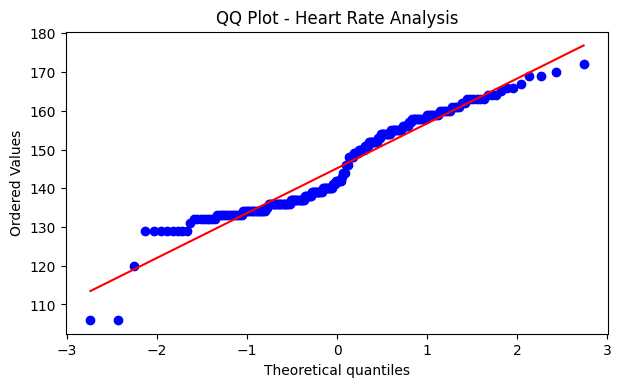

In [ ]:
pylab.figure(figsize=(7,4))
ss.probplot(df['Lifetouch Heart Rate'], plot = pylab)
pylab.title('QQ Plot - Heart Rate Analysis')
pylab.show()

Q-Q Plot to check Normal Distribution of attribute


Depending on the characteristics of a time series, it can be modelled with either an additive or multiplicative approach. This means that each observation in the series can be represented by either the sum or product of the components.


**This code is used to decompose a given target variable into its seasonal, trend and residual components. The seasonal_decompose() function from the statsmodels library is used to decompose the target variable. The function takes three parameters - the target variable, the chosen decomposition model (multiplicative or additive) and the period of the seasonality. Then, the Decompose object is stored in two variables - result_mul and result_add, which are the decomposition results for multiplicative and additive models respectively. Finally, the plot() method is used to visualize the decomposition results.**

Text(0.5, 0.98, 'Multiplicative Decompose')

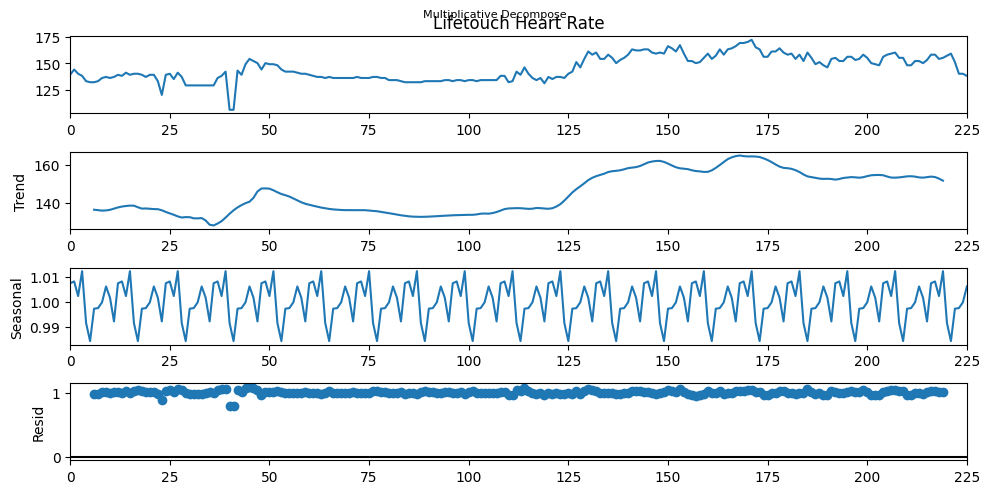

In [ ]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df[input_target], model='multiplicative', period=input_seasonality)

# Additive Decomposition
result_add = seasonal_decompose(df[input_target], model='additive', period=input_seasonality)

# Plot
plt.rcParams.update({'figure.figsize': (10,5)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=8)


**This code is plotting an additive decompose of a data set. The code creates an additive decompose object, then plots it with a title of 'Additive Decompose.' The font size for the title is set to 8.**

Text(0.5, 0.98, 'Additive Decompose')

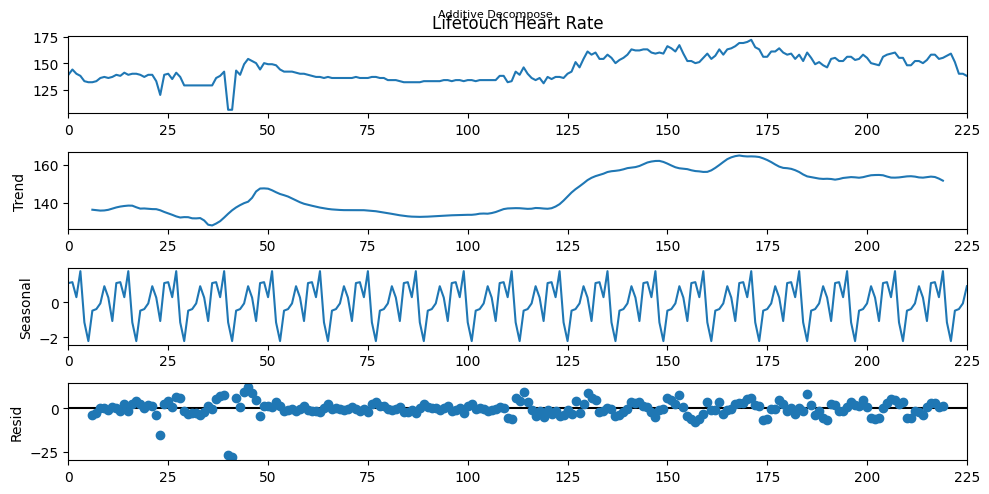

In [ ]:
result_add.plot().suptitle('Additive Decompose', fontsize=8)

There are multiple tests to test if a time series is stationary or not. The most commonly used 
is the ADF test, where the null hypothesis is the time series possesses a unit root and is nonstationary. So, if the P-Value in the ADH test is less than the significance level (0.05), we reject 
the null hypothesis.


**This code performs an Augmented Dickey-Fuller test on the input target variable from the dataframe df. The ADF test is used to test for stationarity in a time series. The test returns a statistic and a p-value, as well as a set of critical values. The p-value represents the probability that the null hypothesis is true, and if it is below a certain threshold (usually 0.05) then the null hypothesis can be rejected and we can conclude that the time series is stationary. The critical values are used to compare the ADF statistic to and determine whether the null hypothesis should be rejected or not.**

In [ ]:
# ADF Test
result = adfuller(df[input_target].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.0062983264332157
p-value: 0.28381834919001564
Critial Values:
   1%, -3.4602906385073884
Critial Values:
   5%, -2.874708679520702
Critial Values:
   10%, -2.573788599127782


**This code is used to check whether a time series is stationary or not. It uses the KPSS test, which is a statistical test for stationarity. The code prints out the p-value of the KPSS test and the result of whether the time series is stationary or not. A p-value less than 0.05 indicates that the series is not stationary.**

Since the p-value obtained 0.28 is greater than significance level 0.05, we accept the null 
hypothesis i.e., time series is not stationary.


In [ ]:
# check stationarity of the series
import statsmodels.api as sm

def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value}')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [ ]:
check_stationarity(df['Lifetouch Heart Rate'])

p value: 0.01
Result: The series is not stationary 



**This code is plotting a graph to help identify the order of differencing needed for a time series. It plots the original data in the plot located in the first row and first column, plots the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the original data in the plots located in the first row and second and third columns respectively, plots the differenced data in the second row and first column, plots the ACF and PACF of the differenced data in the second row and second and third columns respectively, and plots the double-differenced data in the third row and first column, and plots the ACF and PACF of the double-differenced data in the third row and second and third columns respectively.**

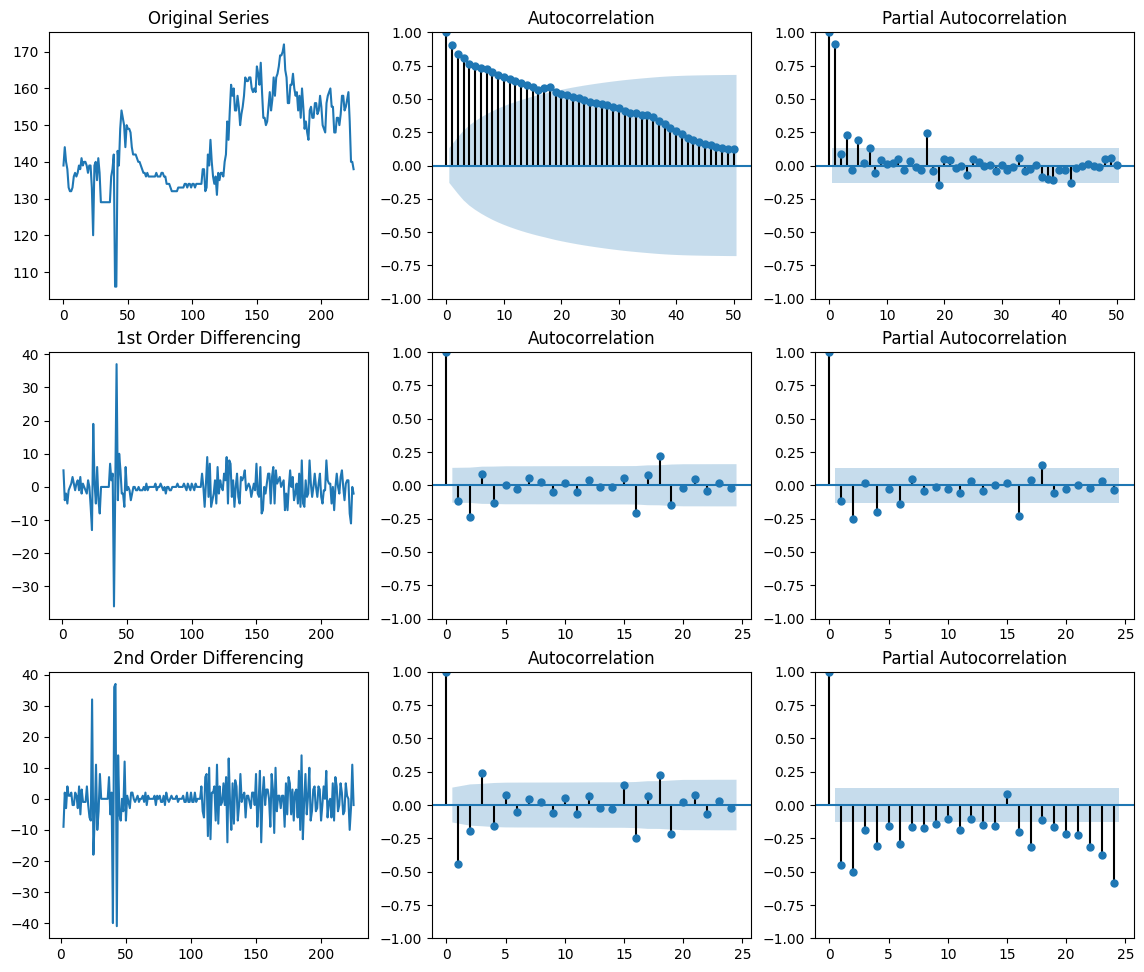

In [ ]:
# Original Series

fig, axes = plt.subplots(3, 3, figsize=(14,12), dpi= 100)
axes[0, 0].plot(df[input_target]);
axes[0, 0].set_title('Original Series')
plot_acf(df[input_target],lags=50, ax=axes[0, 1])
plot_pacf(df[input_target], lags=50, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(df[input_target].diff()); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df[input_target].diff().dropna(), ax=axes[1, 1])
plot_pacf(df[input_target].diff().dropna(), ax=axes[1, 2])


# 2nd Differencing
axes[2, 0].plot(df[input_target].diff().diff()); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df[input_target].diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(df[input_target].diff().diff().dropna(), ax=axes[2, 2])

plt.show();

The right order of differencing is the minimum difference required to get a near-stationary 
series that roams around a defined mean and the ACF plot reaches zero fairly quick.
If the autocorrelations are positive for many numbers of lags (10 or more), then the series 
needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too 
negative, then the series is probably over-differenced

In [ ]:
# ADF Test for 1 order of differencing
result = adfuller(df[input_target].diff().dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -8.370466584275603
p-value: 2.67086003824761e-13
Critial Values:
   1%, -3.460567372610299
Critial Values:
   5%, -2.874829809033386
Critial Values:
   10%, -2.573853225954421


In [ ]:
# ADF Test for 2 order of differencing
result = adfuller(df[input_target].diff().diff().dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.9324288311508155
p-value: 2.3633341725558015e-07
Critial Values:
   1%, -3.4621857592784546
Critial Values:
   5%, -2.875537986778846
Critial Values:
   10%, -2.574231080806213


In [ ]:
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,2015-08-17 15:09:00,139.0,41.0,92.0,140.0
1,2015-08-17 15:10:00,144.0,40.0,92.0,140.0
2,2015-08-17 15:11:00,140.0,42.0,89.0,144.0
3,2015-08-17 15:12:00,138.0,45.0,93.0,141.0
4,2015-08-17 15:13:00,133.0,42.0,94.0,134.0


**This code is splitting a dataframe (df) into two parts, train and test. The train_pct variable is used to determine what percentage of the data should be used for the training data. The train_size variable is then calculated by multiplying the length of the dataframe by the train_pct. The test_size is then calculated by subtracting the train_size from the length of the dataframe. The train and test variables are then created using the train_size and test_size variables to determine the indices for the dataframe.**

In [ ]:
train_pct = 0.80
train_size = int(len(df) * train_pct)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:]

In [ ]:
print('Train Data :',train.shape)
print('Test Data :',test.shape)

Train Data : (180, 5)
Test Data : (46, 5)


**This code is for creating an auto-sarimax model. The auto_arima function from the pm library is used to automatically identify the best parameters for the SARIMAX model. The parameters that are passed to the function are the values for the input target variable, the exogenous variables, the start and end values for the p and q parameters, the seasonal frequency if applicable, the d and max_D values, the error action, and the maximum order for the model. The model summary and diagnostics are then printed and the model is returned.**

# Auto Sarimax Model

In [ ]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(train[input_target], exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = True, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

**This code is used to train a simple exponential smoothing model. It requires the input of a time series array 'y' which is converted to an array using np.asarray(). The model is then fit using the smoothing_level and optimized parameters. Finally, the model summary is printed out.**

# Simple Exponential Smoothing model

Single Exponential Smoothing is a time series forecasting algorithm for univariate data which 
doesn't have a trend or seasonality. Only one parameter is required for SES - alpha (a). It is the smoothing coefficient

In [ ]:
def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

**This code is used to create a Holt-Winters model to forecast a time series. The model uses Exponential Smoothing, with the trend and seasonality both set to 'add'. The input is an array of the time series values, and the seasonality parameter should be the number of periods in the seasonality of the time series. The model is then outputted and a summary of the model is printed.**

# Holt-Winters model

Holt-Winters is a time series forecasting algorithm. It models three aspects of the time series: 
a typical value (average), a slope (trend) over time, and a cyclical repeating pattern 
(seasonality). We need to pass on the parameter seasonality to it.


In [ ]:
def model_holt_winters(y, seasonality):
    
    # Train model
    model = ExponentialSmoothing(np.asarray(y) ,seasonal_periods=seasonality ,trend='add', seasonal='add',).fit()
    
    # Model summary 
    print(model.summary())
    
    return model

**This code is used to get predictions from a given time series algorithm, model, train and test data, target variable, and optional exogenous variable. The code first checks which algorithm is used, and depending on the algorithm, either predicts the values of the test data or forecasts the values of the test data. The resulting predictions are returned as a Pandas Series object.**

In [ ]:
def get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None):
    
    print("------------- Get Predictions --------------- \n")
    # Get prediction for test duration
    if input_ts_algo == "manual_sarima":
        predictions = pd.Series(model.predict(len(train) + 1, len(train) + len(test), typ = 'levels').rename("Predictions")).reset_index(drop = True)
    elif input_ts_algo in ["auto_arima", "auto_sarima", "auto_sarimax"]:
        predictions = pd.Series(model.predict(len(test), exogenous = exogenous_variable)).reset_index(drop = True)
    else:
        predictions = pd.Series(model.forecast(len(test))).reset_index(drop = True)
    return predictions

**This code calculates the Mean Absolute Percentage Error (MAPE). MAPE is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation. It measures the size of the error in percentage terms. **
**The code takes two numpy arrays, y_true (the true values) and y_pred (the predicted values) as input and returns the mean absolute percentage error between the two values. This is done by finding the difference between the two arrays, dividing by the true value and then taking the mean of this value, multiplied by 100.**

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**This code creates a scatter plot that visualizes the relationship between actual values and the errors in the predictions. The code first creates a dataframe containing the actual values and the predictions. It then calculates the error by subtracting the prediction from the actual value. The code then creates a scatter plot with the actual values on the x-axis and the errors on the y-axis. The plot is labeled and titled to indicate what it is showing.**

In [ ]:
def analyse_error(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    plt.scatter(validation_df.actual, validation_df.error)
    plt.xlabel("Actual")
    plt.ylabel("Errors")
    plt.title('Residual Error Analysis')
    plt.show()

**This code is used to evaluate the performance of a machine learning model. It begins by printing some metrics like MAPE (mean absolute percentage error), MAE (mean absolute error), RMSE (root mean squared error) and R2 Score (coefficient of determination). Then, it uses the analyse_error() function to analyse the errors in the prediction. Finally, it plots a graph of the actual vs predicted values to show the results.**

# Model Evauations

In [ ]:
def evaluate_model(actuals, predictions, input_target = input_target):
    
    print("------------- Model Evaluations --------------- \n")
    
    print("MAPE : ", mean_absolute_percentage_error(actuals, predictions))
    print("MAE  : ", mean_absolute_error(actuals, predictions))
    print("RMSE  : ", mean_squared_error(actuals, predictions, squared=False))
    print("R2 Score  : ", r2_score(actuals, predictions))

    
    analyse_error(actuals, predictions)
  
    # Plot actual vs predicted
    predictions.plot(legend = True, label = "Prediction", xlabel = "Index", ylabel = input_target,  figsize=(10, 7)) 
    actuals.plot(legend = True, label = "Actual");
    plt.title("Actual vs Predicted", fontsize = 12)

**This code is a script that allows users to input parameters such as target variable, exogenous variable, and time series algorithm to use for forecasting. It then uses the specified algorithm to generate predictions and evaluates the model by comparing the actuals with the predictions. It also provides analysis of the errors.**

------------- Auto ARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1098.136, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1110.876, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1111.430, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1108.083, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1108.963, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1096.204, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1098.139, Time=0.33 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1100.146, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1106.166, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1109.600, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1095.869, Time=0.21 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1097.866, Time=0.53 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=1097.866, Time=0.59 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=

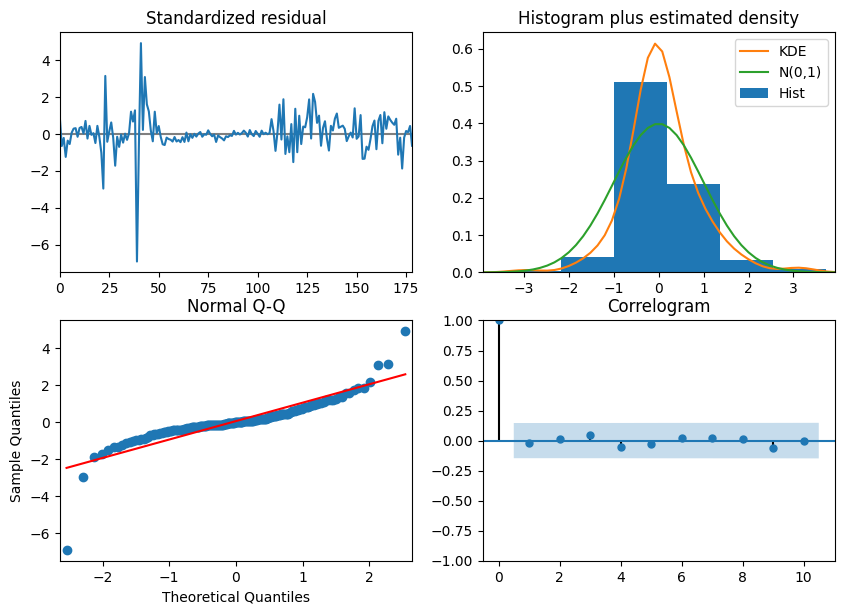

------------- Get Predictions --------------- 

------------- Model Evaluations --------------- 

MAPE :  5.426443327368852
MAE  :  8.114553914358714
RMSE  :  9.604260688575591
R2 Score  :  -2.530053140773253


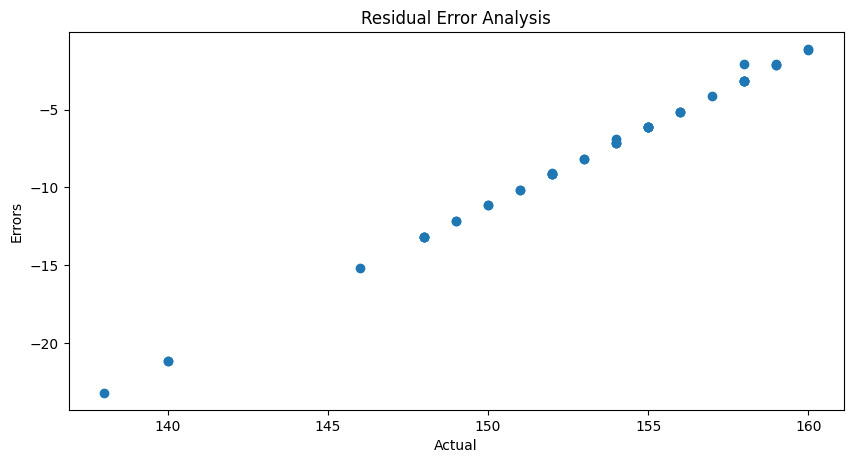

0     160.070764
1     161.090063
2     160.864296
3     161.198236
4     161.055973
5     161.181806
6     161.112510
7     161.163700
8     161.132376
9     161.153954
10    161.140170
11    161.149405
12    161.143403
13    161.147380
14    161.144777
15    161.146494
16    161.145367
17    161.146109
18    161.145621
19    161.145942
dtype: float64


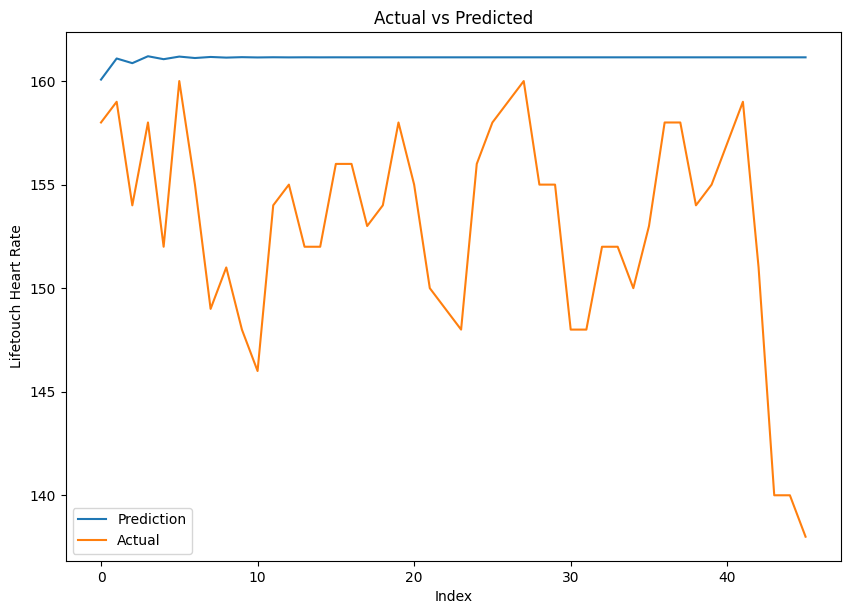

In [ ]:
# Get actual values
actuals = test[input_target].reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target)
    evaluate_model(actuals, predictions)
    print(predictions[:20])
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = train[input_target], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_ex_variable].values.reshape(-1, 1))
    predictions = get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = train[input_ex_variable].values.reshape(-1, 1))
    evaluate_model(actuals, predictions)


elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = train[input_target])
    predictions = get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'holt_winters':
    
    print("------------- Holt Winters --------------- \n")
    model = model_holt_winters(y = train[input_target], seasonality = input_seasonality)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = None)
    evaluate_model(actuals, predictions)

**This code is used to create a simple exponential smoothing model. The SimpleExpSmoothing() function from the statsmodels library is used to fit the model to the data, y. The train model parameter is used to set the smoothing level and optimize the model. The model summary prints a summary of the model's performance.**

In [ ]:
input_ts_algo = 'simple_exponential_smoothing'

In [ ]:
def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=True)
    
    # Model summary 
    print(model.summary())
    
    return model

**This code is used to obtain predictions from a time series algorithm. It takes in four parameters: input_ts_algo, model, train, test, input_target_variable, and exogenous_variable (optional). Depending on the input_ts_algo, the code will use the appropriate method to generate predictions. For example, if the input_ts_algo is manual_sarima, the code will use the model.predict() method to generate the predictions. If the input_ts_algo is auto_arima, auto_sarima, or auto_sarimax, the code will use the model.predict() method with the exogenous_variable as an argument. Finally, if the input_ts_algo is something else, the code will use the model.forecast() method to generate the predictions. The predictions are then returned as a Pandas Series.**

In [ ]:
def get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = None):
    
    print("------------- Get Predictions --------------- \n")
    # Get prediction for test duration
    if input_ts_algo == "manual_sarima":
        predictions = pd.Series(model.predict(len(train) + 1, len(train) + len(test), typ = 'levels').rename("Predictions")).reset_index(drop = True)
    elif input_ts_algo in ["auto_arima", "auto_sarima", "auto_sarimax"]:
        predictions = pd.Series(model.predict(len(test), exogenous = exogenous_variable)).reset_index(drop = True)
    else:
        predictions = pd.Series(model.forecast(len(test))).reset_index(drop = True)
    return predictions

**This code calculates the mean absolute percentage error (MAPE) between the true and predicted values. The MAPE is calculated by first taking the difference between the true and predicted values, dividing by the true values, and then taking the absolute value of the result. The final step is to take the mean of the absolute values and then multiply by 100 to get the percent error.**

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


**This code is used to analyse the error between actual values and predictions. It creates a dataframe with the actual values and predictions and then calculates the error. It then creates a scatter plot with the x-axis being the actual values and the y-axis being the errors. The title of the plot is Residual Error Analysis.**

In [ ]:
def analyse_error(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    plt.scatter(validation_df.actual, validation_df.error)
    plt.xlabel("Actual")
    plt.ylabel("Errors")
    plt.title('Residual Error Analysis')
    plt.show()

**This code evaluates a given model by calculating the MAPE, MAE, RMSE and R2 score for the given actual and predicted values. It also calls the analyze_error() function to visualize the error and finally plots the actual vs predicted values.**

In [ ]:
def evaluate_model(actuals, predictions, input_target = input_target):
    
    print("------------- Model Evaluations --------------- \n")
    
    print("MAPE : ", mean_absolute_percentage_error(actuals, predictions))
    print("MAE  : ", mean_absolute_error(actuals, predictions))
    print("RMSE  : ", mean_squared_error(actuals, predictions, squared=False))
    print("R2 Score  : ", r2_score(actuals, predictions))

    
    analyse_error(actuals, predictions)
  
    # Plot actual vs predicted
    predictions.plot(legend = True, label = "Prediction", xlabel = "Index", ylabel = input_target,  figsize=(10, 7)) 
    actuals.plot(legend = True, label = "Actual");
    plt.title("Actual vs Predicted", fontsize = 12)

**This code is a Python script which implements a time series algorithm to predict future values of a target variable. It takes in input parameters such as the dataset, target variable, exogenous variable, seasonality, and time series algorithm to be used. It then uses these parameters to build the model, make predictions, and evaluate the model performance. The available algorithms are Auto ARIMA, Auto SARIMA, Auto SARIMAX, Simple Exponential Smoothing, and Holt Winters. It also provides a visual of the predictions versus the actual values.**

------------- Simple Exponential Smoothing --------------- 

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  endog   No. Observations:                  180
Model:             SimpleExpSmoothing   SSE                           4944.714
Optimized:                       True   AIC                            600.361
Trend:                           None   BIC                            606.747
Seasonal:                        None   AICC                           600.590
Seasonal Periods:                None   Date:                 Tue, 14 Feb 2023
Box-Cox:                        False   Time:                         09:17:27
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.6000000                alpha             

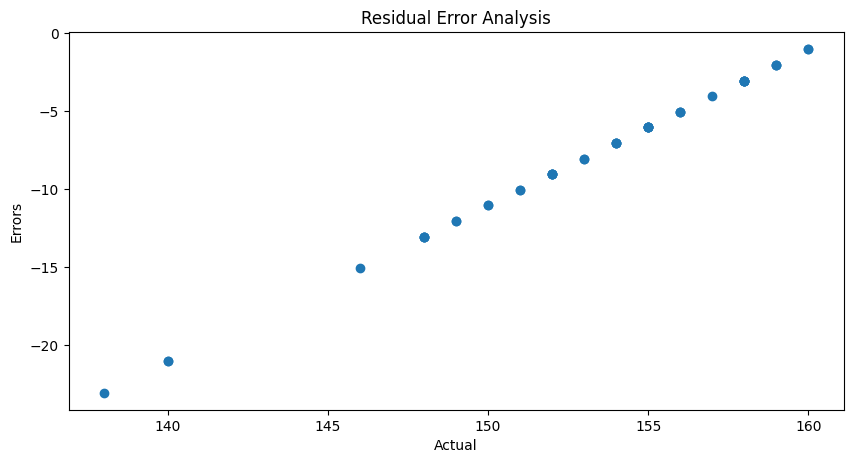

0     161.027836
1     161.027836
2     161.027836
3     161.027836
4     161.027836
5     161.027836
6     161.027836
7     161.027836
8     161.027836
9     161.027836
10    161.027836
11    161.027836
12    161.027836
13    161.027836
14    161.027836
15    161.027836
16    161.027836
17    161.027836
18    161.027836
19    161.027836
dtype: float64


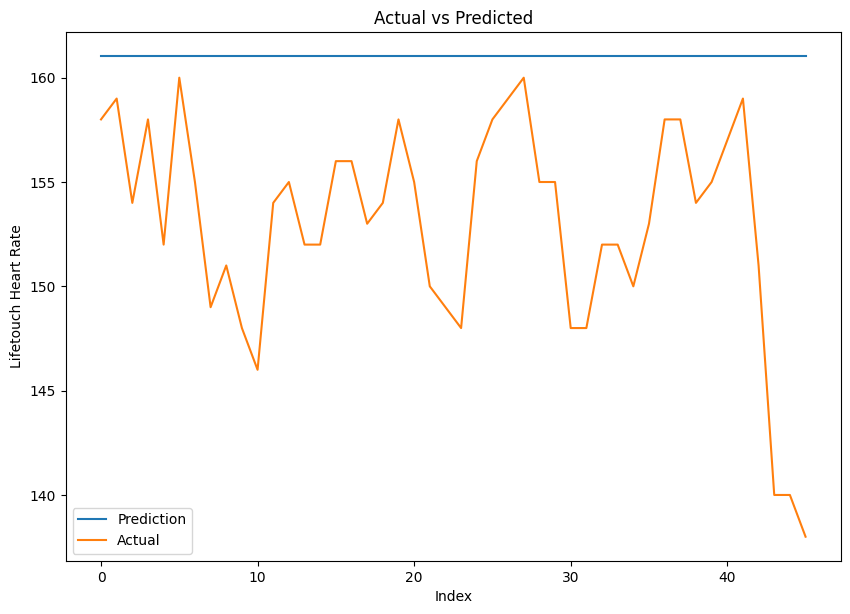

In [ ]:
# Get actual values
actuals = test[input_target].reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target)
    evaluate_model(actuals, predictions)
    print(predictions[:20])
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = train[input_target], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_ex_variable].values.reshape(-1, 1))
    predictions = get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = train[input_ex_variable].values.reshape(-1, 1))
    evaluate_model(actuals, predictions)


elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = train[input_target])
    predictions = get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    print(predictions[:20])
    
elif input_ts_algo == 'holt_winters':
    
    print("------------- Holt Winters --------------- \n")
    model = model_holt_winters(y = train[input_target], seasonality = input_seasonality)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = None)
    evaluate_model(actuals, predictions)

In [ ]:
input_ts_algo = 'holt_winters'

In [ ]:
def model_holt_winters(y, seasonality):
    
    # Train model
    model = ExponentialSmoothing(np.asarray(y) ,seasonal_periods=seasonality ,trend='add', seasonal='add',).fit()
    
    # Model summary 
    print(model.summary())
    
    return model

In [ ]:
def get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = None):
    
    print("------------- Get Predictions --------------- \n")
    # Get prediction for test duration
    if input_ts_algo == "manual_sarima":
        predictions = pd.Series(model.predict(len(train) + 1, len(train) + len(test), typ = 'levels').rename("Predictions")).reset_index(drop = True)
    elif input_ts_algo in ["auto_arima", "auto_sarima", "auto_sarimax"]:
        predictions = pd.Series(model.predict(len(test), exogenous = exogenous_variable)).reset_index(drop = True)
    else:
        predictions = pd.Series(model.forecast(len(test))).reset_index(drop = True)
    return predictions

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def analyse_error(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    plt.scatter(validation_df.actual, validation_df.error)
    plt.xlabel("Actual")
    plt.ylabel("Errors")
    plt.title('Residual Error Analysis')
    plt.show()

In [ ]:
def evaluate_model(actuals, predictions, input_target_variable = input_target):
    
    print("------------- Model Evaluations --------------- \n")
    
    print("MAPE : ", mean_absolute_percentage_error(actuals, predictions))
    print("MAE  : ", mean_absolute_error(actuals, predictions))
    print("RMSE  : ", mean_squared_error(actuals, predictions, squared=False))
    print("R2 Score  : ", r2_score(actuals, predictions))

    
    analyse_error(actuals, predictions)
  
    # Plot actual vs predicted
    predictions.plot(legend = True, label = "Prediction", xlabel = "Index", ylabel = input_target_variable,  figsize=(10, 7)) 
    actuals.plot(legend = True, label = "Actual");
    plt.title("Actual vs Predicted", fontsize = 12)

------------- Holt Winters --------------- 

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  180
Model:             ExponentialSmoothing   SSE                           4439.305
Optimized:                         True   AIC                            608.953
Trend:                         Additive   BIC                            660.041
Seasonal:                      Additive   AICC                           613.202
Seasonal Periods:                    12   Date:                 Tue, 14 Feb 2023
Box-Cox:                          False   Time:                         09:17:28
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7506182                alpha  

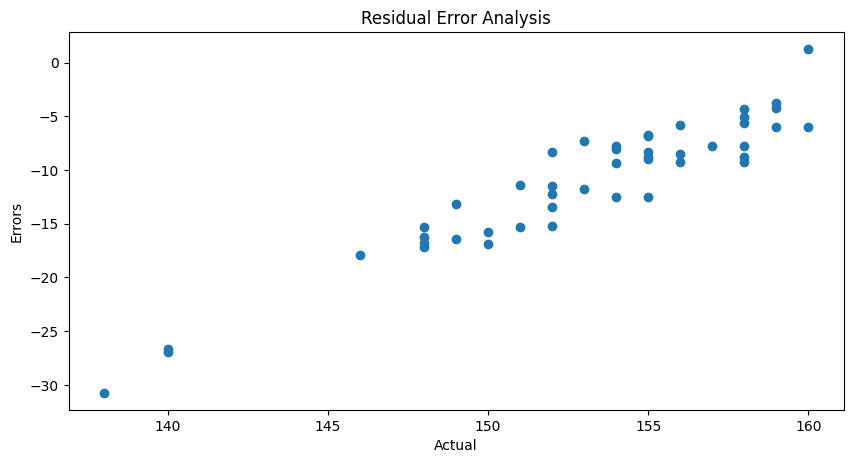

0     162.299326
1     162.765676
2     162.031476
3     163.031964
4     160.297627
5     158.764145
6     161.831342
7     162.164435
8     162.430664
9     164.230833
10    163.897699
11    161.764384
12    163.793045
13    164.259395
14    163.525195
15    164.525683
16    161.791346
17    160.257864
18    163.325061
19    163.658154
dtype: float64


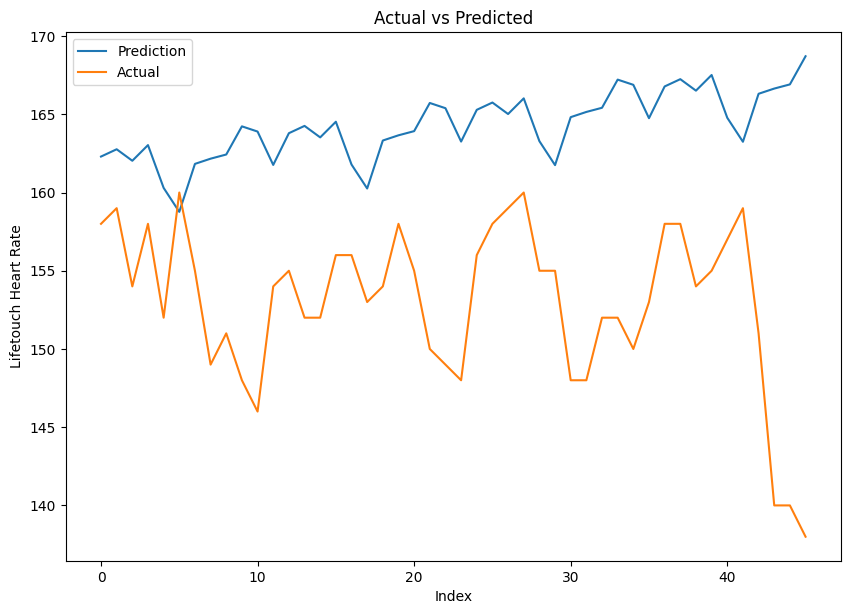

In [ ]:
# Get actual values
actuals = test[input_target].reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target)
    evaluate_model(actuals, predictions)
    print(predictions[:20])
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = train[input_target], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_ex_variable].values.reshape(-1, 1))
    predictions = get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = train[input_ex_variable].values.reshape(-1, 1))
    evaluate_model(actuals, predictions)


elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = train[input_target])
    predictions = get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'holt_winters':
    
    print("------------- Holt Winters --------------- \n")
    model = model_holt_winters(y = train[input_target], seasonality = input_seasonality)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    print(predictions[:20])